In [1]:
!pip install pandas numpy matplotlib yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------------------------ --------------- 1.8/3.0 MB 10.1 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 9.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 7.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139097 sha256=f945805fd4094d581dd2aac395418f43be7d7619883af1803caf5313dac9ca20
  Stored in directory: c:\users\pakala.sip2025\appdata\local\pip\cache\wheels\1a\57\6a\bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Success

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [20]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    
    # Only include columns that exist
    expected_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    available_cols = [col for col in expected_cols if col in data.columns]
    return data[available_cols]


In [27]:
def moving_average_strategy(data, short_window, long_window):
    data['short_mavg'] = data['Close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['Close'].rolling(window=long_window).mean()
    data['signal'] = 0
    data.loc[short_window:, 'signal'] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


def MACD(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def macd_strategy(data, short_window, long_window, signal_window):
    data['macd'], data['signal_line'] = MACD(data, short_window, long_window, signal_window)
    data['signal'] = 0
    data.loc[signal_window:, 'signal'] = np.where(data['macd'][signal_window:] > data['signal_line'][signal_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data

In [42]:
def backtest(data, initial_capital):
    # Initialize positions and portfolio
    positions = pd.DataFrame(index=data.index)
    positions['Stock'] = 0

    portfolio = pd.DataFrame(index=data.index)
    portfolio['cash'] = initial_capital
    portfolio['holdings'] = 0.0
    portfolio['total'] = initial_capital
    portfolio['returns'] = 0.0

    for i in range(1, len(data)):
        signal = int(data['signal'].iloc[i])  # make sure it's a scalar
        price = float(data['Close'].iloc[i])  # scalar price
        prev_cash = float(portfolio['cash'].iloc[i - 1])
        prev_stock = int(positions['Stock'].iloc[i - 1])

        # Buy
        if signal == 1 and prev_cash >= price * 100:
            positions.iloc[i, positions.columns.get_loc('Stock')] = prev_stock + 100
            portfolio.iloc[i, portfolio.columns.get_loc('cash')] = prev_cash - price * 100

        # Sell
        elif signal == 0 and prev_stock >= 100:
            positions.iloc[i, positions.columns.get_loc('Stock')] = prev_stock - 100
            portfolio.iloc[i, portfolio.columns.get_loc('cash')] = prev_cash + price * 100

        # Hold
        else:
            positions.iloc[i, positions.columns.get_loc('Stock')] = prev_stock
            portfolio.iloc[i, portfolio.columns.get_loc('cash')] = prev_cash

        # Update holdings and total
        stock = positions.iloc[i, positions.columns.get_loc('Stock')]
        holdings = stock * price
        portfolio.iloc[i, portfolio.columns.get_loc('holdings')] = holdings
        portfolio.iloc[i, portfolio.columns.get_loc('total')] = holdings + portfolio.iloc[i, portfolio.columns.get_loc('cash')]

        # Calculate return
        if i > 1:
            prev_total = portfolio.iloc[i - 1, portfolio.columns.get_loc('total')]
            curr_total = portfolio.iloc[i, portfolio.columns.get_loc('total')]
            if prev_total != 0:
                portfolio.iloc[i, portfolio.columns.get_loc('returns')] = (curr_total - prev_total) / prev_total

    return portfolio


In [45]:
def generate_report(portfolio, initial_capital):
    total_return = portfolio['total'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio['total'], label='Portfolio Value')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed


Total Return: 32.02%
Annualized Return: 9.74%
Annualized Volatility: 16.47%
Sharpe Ratio: 0.59


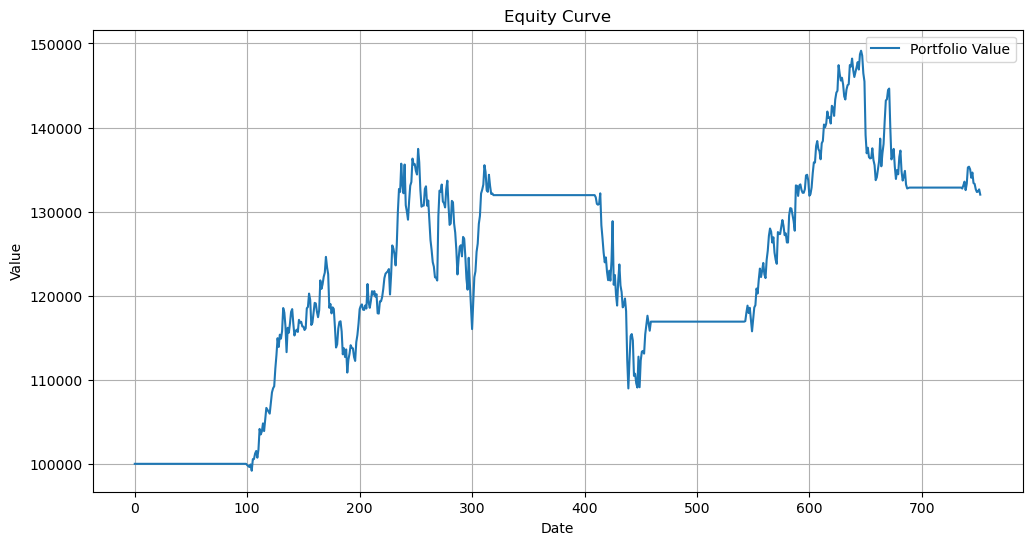

In [46]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = moving_average_strategy(data, short_window=40, long_window=100)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


[*********************100%***********************]  1 of 1 completed


Total Return: 42.25%
Annualized Return: 12.52%
Annualized Volatility: 15.63%
Sharpe Ratio: 0.80


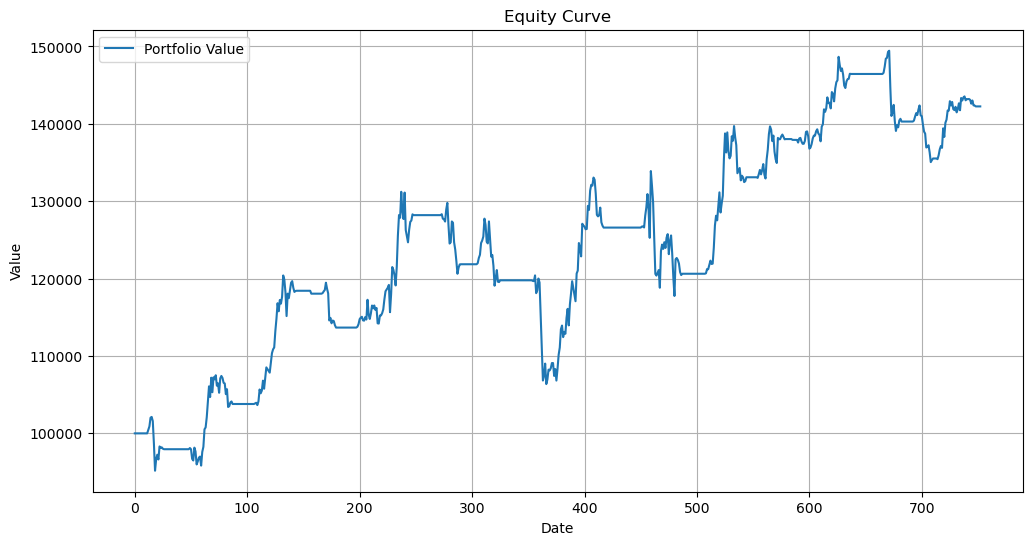

In [47]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = macd_strategy(data, short_window=12, long_window=26, signal_window=9)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


In [51]:
def new_strategy(data):
    # --- MACD Calculation ---
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=9, adjust=False).mean()
    data['macd'] = macd
    data['macd_signal'] = signal_line

    # --- RSI Calculation ---
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['rsi'] = rsi

    # --- Signal Logic ---
    data['signal'] = 0  # default
    data['signal'] = ((data['macd'] > data['macd_signal']) & (data['rsi'] < 50)).astype(int)

    # Optional: Use 0 signal to mean "sell" (or you can leave it to portfolio logic)
    return data


[*********************100%***********************]  1 of 1 completed


Total Return: 7.94%
Annualized Return: 2.59%
Annualized Volatility: 2.03%
Sharpe Ratio: 1.28


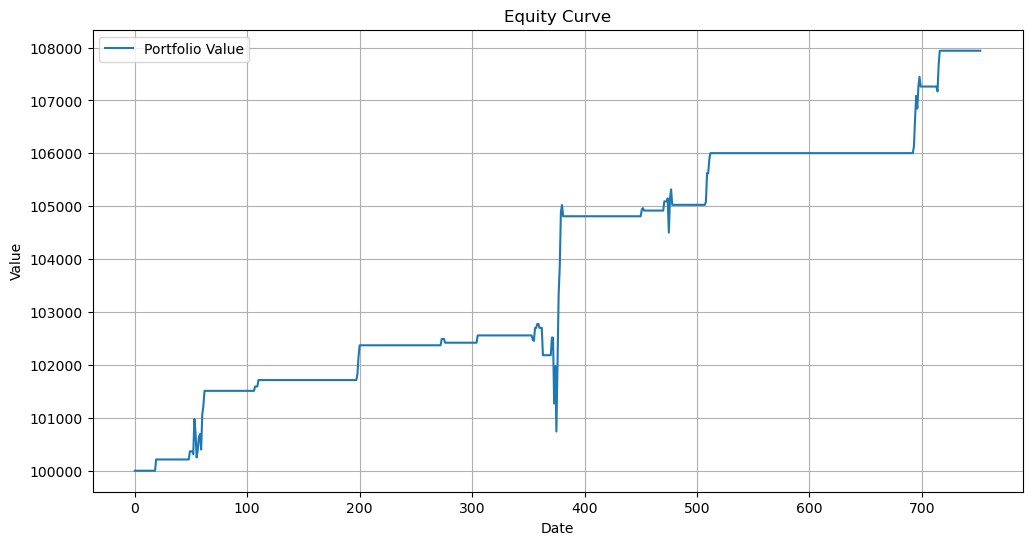

In [52]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = new_strategy(data)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


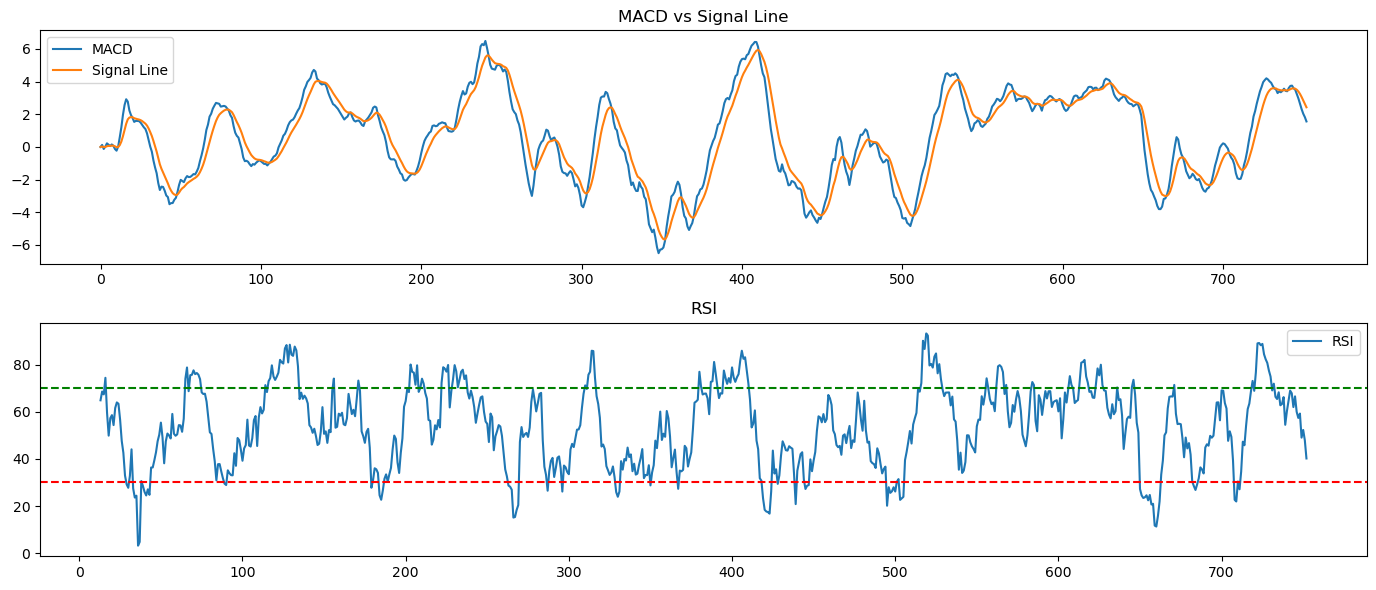

In [50]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(data['macd'], label='MACD')
plt.plot(data['macd_signal'], label='Signal Line')
plt.title('MACD vs Signal Line')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['rsi'], label='RSI')
plt.axhline(30, color='red', linestyle='--')
plt.axhline(70, color='green', linestyle='--')
plt.title('RSI')
plt.legend()

plt.tight_layout()
plt.show()
